In [292]:
import pandas as pd
import numpy as np

file1 = "PSP_FLD_L2_AEB.p1.csv"
file2 = "PSP_FLD_L2_AEB.p2.csv"
file3 = "PSP_FLD_L2_AEB.p3.csv"

df1 = pd.read_csv(file1, low_memory=False)
df2 = pd.read_csv(file2, low_memory=False)
df3 = pd.read_csv(file3, low_memory=False)

# Concatenate dataframes
combined_df = pd.concat([df1, df2, df3], ignore_index=True)
combined_df.to_csv("PSP_FLD_L2_AEB_complete.csv", index=False)

# Output number of rows and columns
num_rows, num_columns = combined_df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")


Number of rows: 354770
Number of columns: 15


In [293]:
psp_df = pd.read_csv("PSP_FLD_L2_AEB_complete.csv", low_memory=False)

# Forward fill all columns except the col 1
psp_df.iloc[:, 1:] = psp_df.iloc[:, 1:].ffill()
psp_df.to_csv("PSP_FLD_L2_AEB_complete_filled.csv", index=False)

print("PSP_FLD_L2_AEB_complete_filled.csv")

PSP_FLD_L2_AEB_complete_filled.csv


In [294]:
##Format timestamps and concatenate datasets

psp_df = pd.read_csv("PSP_FLD_L2_AEB_complete_filled.csv", low_memory=False)
ac_df = pd.read_csv("AC_H3_SW2.csv", low_memory=False)

#Convert the timestamp column to datetime
psp_df['yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(psp_df['yyyy-mm-ddThh:mm:ss.sssZ'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')
ac_df['yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(ac_df['yyyy-mm-ddThh:mm:ss.sssZ'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

#Concatenate the datasets
combined_df = pd.concat([psp_df, ac_df], ignore_index=True)

combined_df.drop_duplicates(subset=['yyyy-mm-ddThh:mm:ss.sssZ'], keep='first', inplace=True)

combined_df.sort_values(by='yyyy-mm-ddThh:mm:ss.sssZ', inplace=True)

#Forward fill missing values
combined_df.ffill(inplace=True)

combined_df.to_csv("Final_dataset.csv", index=False)

print("Final_dataset.csv")

#Output number of rows and columns
num_rows, num_columns = combined_df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")


Final_dataset.csv
Number of rows: 198295
Number of columns: 22


In [295]:
##Filter errors from concatenating datasets

final_df = pd.read_csv("Final_dataset.csv", low_memory=False)

#Check if value is an integer
def is_integer(value):
    try:
        int(value)
        return True
    except ValueError:
        return False

filtered_final_df = final_df[final_df.iloc[:, 3].apply(is_integer)]

#Load only rows starting from row 6
start_row = 6
filtered_final_df = filtered_final_df.iloc[start_row:].reset_index(drop=True)

filtered_final_df.to_csv("Filtered_Final_dataset.csv", index=False)

print("Filtered_Final_dataset.csv")

#Output number of rows and columns
num_rows, num_columns = filtered_final_df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")


Filtered_Final_dataset.csv
Number of rows: 191558
Number of columns: 22


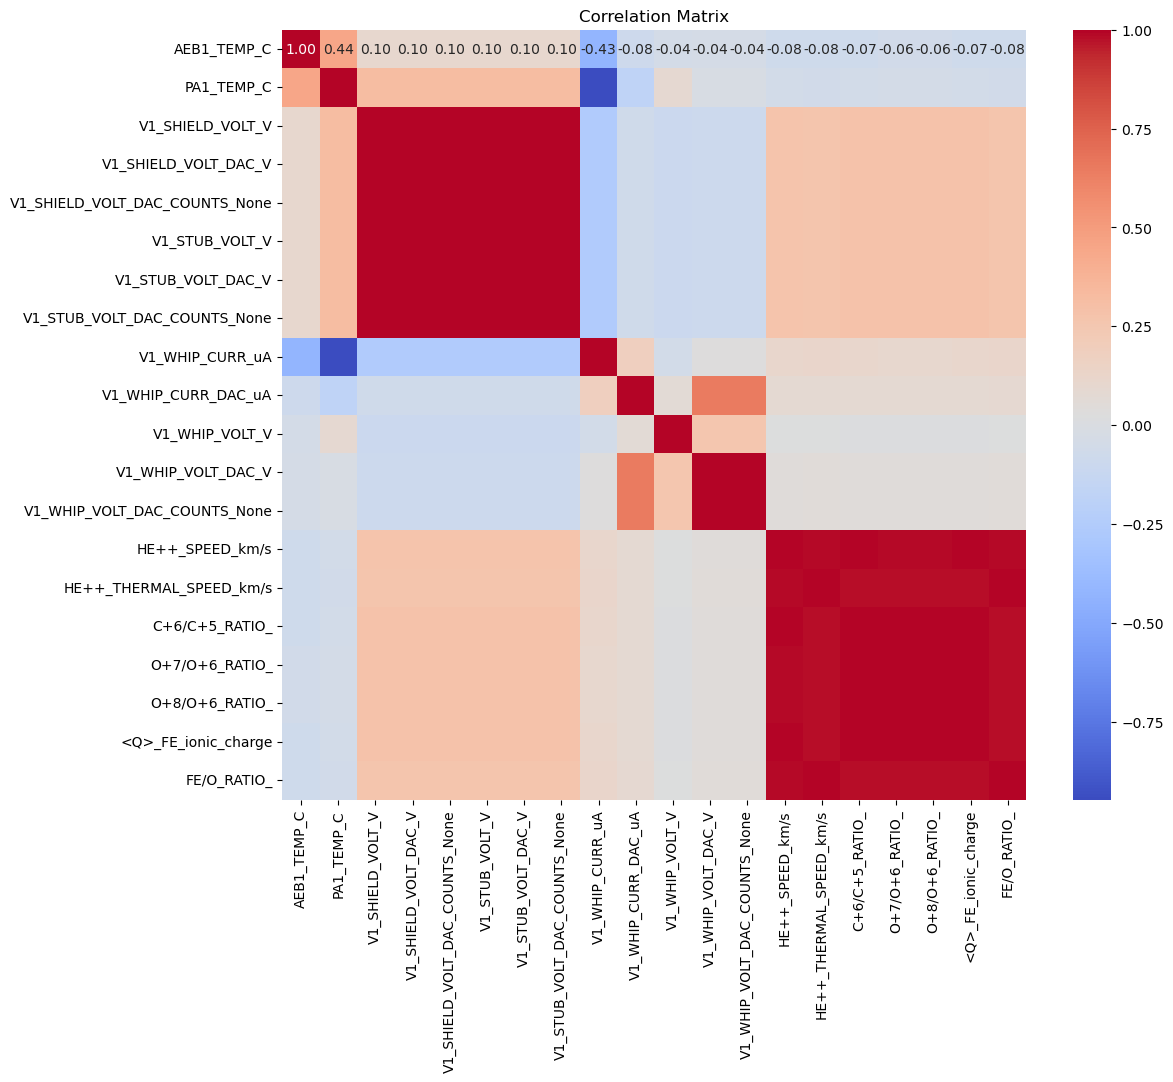

Feature Scores:

AEB1_TEMP_C: 4686.99
PA1_TEMP_C: 12016.31
V1_SHIELD_VOLT_V: 1346.32
V1_SHIELD_VOLT_DAC_V: 1348.18
V1_SHIELD_VOLT_DAC_COUNTS_None: 1348.18
V1_STUB_VOLT_V: 1344.31
V1_STUB_VOLT_DAC_V: 1348.08
V1_STUB_VOLT_DAC_COUNTS_None: 1348.08
V1_WHIP_CURR_uA: 9999.07
V1_WHIP_CURR_DAC_uA: 3688.04
V1_WHIP_VOLT_V: 1540.23
V1_WHIP_VOLT_DAC_V: 5075.33
V1_WHIP_VOLT_DAC_COUNTS_None: 5075.33
HE++_SPEED_km/s: 1007.77
HE++_THERMAL_SPEED_km/s: 979.04
C+6/C+5_RATIO_: 1019.21
O+7/O+6_RATIO_: 1031.28
O+8/O+6_RATIO_: 1035.51
<Q>_FE_ionic_charge: 1023.42
FE/O_RATIO_: 998.57

RFE Feature Ranking:

AEB1_TEMP_C: Rank 16
PA1_TEMP_C: Rank 1
V1_SHIELD_VOLT_V: Rank 11
V1_SHIELD_VOLT_DAC_V: Rank 14
V1_SHIELD_VOLT_DAC_COUNTS_None: Rank 15
V1_STUB_VOLT_V: Rank 6
V1_STUB_VOLT_DAC_V: Rank 12
V1_STUB_VOLT_DAC_COUNTS_None: Rank 13
V1_WHIP_CURR_uA: Rank 2
V1_WHIP_CURR_DAC_uA: Rank 1
V1_WHIP_VOLT_V: Rank 1
V1_WHIP_VOLT_DAC_V: Rank 1
V1_WHIP_VOLT_DAC_COUNTS_None: Rank 1
HE++_SPEED_km/s: Rank 10
HE++_THERMAL_SPEED_km

In [296]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Filtered_Final_dataset.csv", low_memory=False)

#target column handled separately
y = df['V1_RBIAS_None']

#Drop non-numeric columns and handle missing values
X = df.drop(columns=['V1_RBIAS_None'])
X = X.select_dtypes(include=[int, float])

#Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

#Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

#Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

#Correlation Analysis
correlation_matrix = pd.DataFrame(X_scaled, columns=X.columns).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

#Univariate Feature Selection
#Select the top k features based on univariate statistical tests
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_scaled, y)
scores = selector.scores_
features = X.columns

print("Feature Scores:\n")
for feature, score in zip(features, scores):
    print(f"{feature}: {score:.2f}")

#Recursive Feature Elimination (RFE)
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=5)  # Select top 5 features
rfe.fit(X_scaled, y)

#Print RFE results
print("\nRFE Feature Ranking:\n")
for i in range(X.shape[1]):
    print(f"{X.columns[i]}: Rank {rfe.ranking_[i]}")

#Select features based on RFE
selected_features = X.columns[rfe.support_]
print("\nSelected Features based on RFE:\n", selected_features)

#Create new DataFrame with the selected features and the target column
selected_df = df[selected_features.tolist() + ['V1_RBIAS_None']]

print(selected_df)


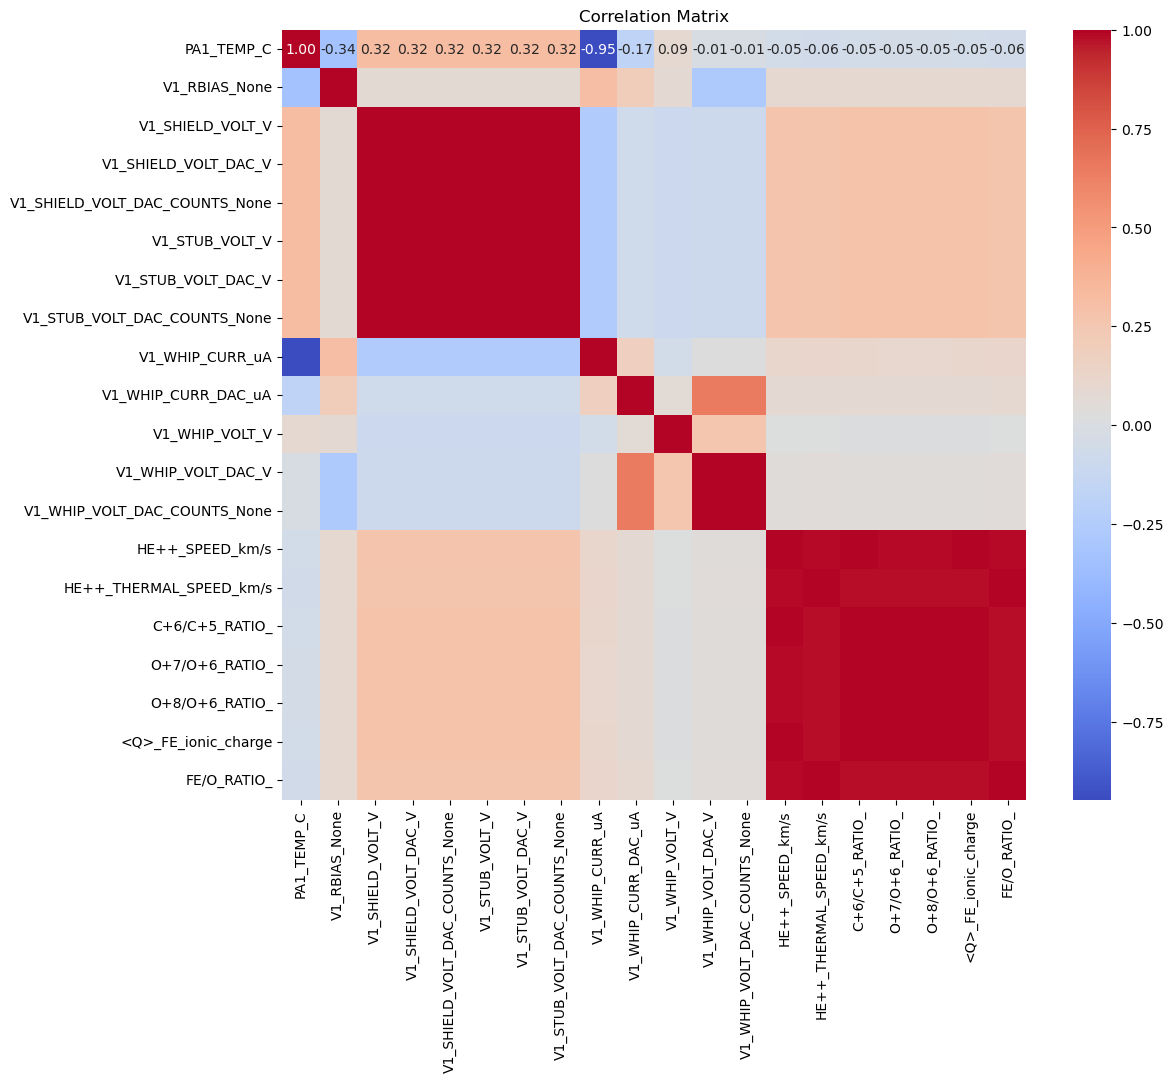

Feature Scores:

PA1_TEMP_C: 47243.64
V1_RBIAS_None: 48.38
V1_SHIELD_VOLT_V: 2083.80
V1_SHIELD_VOLT_DAC_V: 2080.92
V1_SHIELD_VOLT_DAC_COUNTS_None: 2080.92
V1_STUB_VOLT_V: 2094.69
V1_STUB_VOLT_DAC_V: 2081.08
V1_STUB_VOLT_DAC_COUNTS_None: 2081.08
V1_WHIP_CURR_uA: 42292.85
V1_WHIP_CURR_DAC_uA: 1332.21
V1_WHIP_VOLT_V: 366.48
V1_WHIP_VOLT_DAC_V: 285.55
V1_WHIP_VOLT_DAC_COUNTS_None: 285.55
HE++_SPEED_km/s: 1097.06
HE++_THERMAL_SPEED_km/s: 1198.53
C+6/C+5_RATIO_: 1067.02
O+7/O+6_RATIO_: 772.22
O+8/O+6_RATIO_: 774.30
<Q>_FE_ionic_charge: 1065.02
FE/O_RATIO_: 1205.74

RFE Feature Ranking:

PA1_TEMP_C: Rank 7
V1_RBIAS_None: Rank 11
V1_SHIELD_VOLT_V: Rank 4
V1_SHIELD_VOLT_DAC_V: Rank 1
V1_SHIELD_VOLT_DAC_COUNTS_None: Rank 1
V1_STUB_VOLT_V: Rank 3
V1_STUB_VOLT_DAC_V: Rank 1
V1_STUB_VOLT_DAC_COUNTS_None: Rank 1
V1_WHIP_CURR_uA: Rank 15
V1_WHIP_CURR_DAC_uA: Rank 14
V1_WHIP_VOLT_V: Rank 13
V1_WHIP_VOLT_DAC_V: Rank 2
V1_WHIP_VOLT_DAC_COUNTS_None: Rank 1
HE++_SPEED_km/s: Rank 16
HE++_THERMAL_SPEED_km/s

In [297]:
df = pd.read_csv("Filtered_Final_dataset.csv", low_memory=False)

#target column handled separately
y = df['AEB1_TEMP_C']

#Drop non-numeric columns and handle missing values
X = df.drop(columns=['AEB1_TEMP_C'])
X = X.select_dtypes(include=[int, float])

#Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

#Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

#Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

#Correlation Analysis
correlation_matrix = pd.DataFrame(X_scaled, columns=X.columns).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

#Univariate Feature Selection
#Select the top k features based on univariate statistical tests
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_scaled, y)
scores = selector.scores_
features = X.columns

print("Feature Scores:\n")
for feature, score in zip(features, scores):
    print(f"{feature}: {score:.2f}")

#Recursive Feature Elimination (RFE)
model = LinearRegression()
rfe = RFE(model, n_features_to_select=5)  # Select top 5 features
rfe.fit(X_scaled, y)

#Print RFE results
print("\nRFE Feature Ranking:\n")
for i in range(X.shape[1]):
    print(f"{X.columns[i]}: Rank {rfe.ranking_[i]}")

#Select features based on RFE
selected_features = X.columns[rfe.support_]
print("\nSelected Features based on RFE:\n", selected_features)

#Create a new DataFrame with the selected features and the target column
selected_df = df[selected_features.tolist() + [target_column]]

print(selected_df)


After Feature Selection, I choose HE++_SPEED_km/s as the feature to analyze its effects on the PSP AEB

In [299]:
df = pd.read_csv("Filtered_Final_dataset.csv", low_memory=False)

# Remove col 7, 10, 15, 17-22
columns_to_remove = df.columns[[6, 9, 14, 16, 17, 18, 19, 20, 21]]
df.drop(columns=columns_to_remove, inplace=True)

df.to_csv("Filtered_Final_dataset.csv", index=False)

remaining_columns = df.columns
print("Remaining columns:\n")
print(remaining_columns)


Remaining columns:

Index(['yyyy-mm-ddThh:mm:ss.sssZ', 'AEB1_TEMP_C', 'PA1_TEMP_C',
       'V1_RBIAS_None', 'V1_SHIELD_VOLT_V', 'V1_SHIELD_VOLT_DAC_V',
       'V1_STUB_VOLT_V', 'V1_STUB_VOLT_DAC_V', 'V1_WHIP_CURR_uA',
       'V1_WHIP_CURR_DAC_uA', 'V1_WHIP_VOLT_V', 'V1_WHIP_VOLT_DAC_V',
       'HE++_SPEED_km/s'],
      dtype='object')
